# Exploration: optimization of a surface for torque!

In [6]:
import sys, os
import matplotlib as mpl
import scipy as sc
from scipy import interpolate

from motors.simulation import *
from motors.plot import *
prepare_plot()

%reload_ext autoreload
%autoreload 2
%matplotlib inline
mpl.rc('text', usetex=True)
cmap = sns.color_palette("Paired", 10)

In [7]:
def report_force_on_barrier(unbound, bound, position, height=20, file=None):
    """
    Put the variable height barrier in a between `position` and `position + 1`
    and report the force on the barrier.
    """
    
    blocked = Simulation(data_source='manual')
    blocked.unbound = unbound
    blocked.bound = bound
    
    #########################################################################
    blocked.C_intersurface = 10 ** 6     # per mole per second
    blocked.offset_factor = 5.7          # kcal per mol
    blocked.catalytic_rate = 312         # per second
    blocked.cSubstrate = 2.5 * 10 ** -3  # molar
    ########################################################################
    
    blocked.barrier = True
    blocked.barrier_bin = position
    blocked.barrier_height = height
    blocked.simulate(user_energies = True)
        
    bin_width = bin_width = 2 * np.pi / blocked.bins
    if blocked.barrier_bin < blocked.bins - 1:
        apo_force = blocked.ss[blocked.barrier_bin + 1] / bin_width * 0.593 - blocked.ss[blocked.barrier_bin] / bin_width * 0.593
        bound_force = blocked.ss[blocked.bins + blocked.barrier_bin + 1] / bin_width * 0.593 - blocked.ss[blocked.bins + blocked.barrier_bin] / bin_width * 0.593
    else:
        apo_force = blocked.ss[0] / bin_width * 0.593 - blocked.ss[blocked.barrier_bin] / bin_width * 0.593
        bound_force = blocked.ss[blocked.bins + 0] / bin_width * 0.593 - blocked.ss[blocked.bins + blocked.barrier_bin] / bin_width * 0.593

    return apo_force + bound_force, np.mean(blocked.flux_u + blocked.flux_b)

In [8]:
def objective(spline_points):
    x_points = [0, 10, 20, 30, 40, 50, 59]

    xnew = np.arange(60)
    energy = interpolate.spline(x_points, spline_points, xnew=xnew)
    energies.append(energy)  
    
    force, flux = report_force_on_barrier(energy, interpolate.spline(x_points, [3, 4, 5, 0, 1, 2, 3], xnew=xnew), 
                            position=30)
    
    forces.append(force)
    fluxes.append(flux)
    return force

In [10]:
guess = [0, 0, 0, 0, 0, 0, 0]
forces = []
energies = []
fluxes = []
np.random.seed(42)
results = sc.optimize.minimize(objective, guess, method='Nelder-Mead',
                     bounds=((0, 10), (0, 10), (0, 10),
                             (0, 10), (0, 10), (0, 10),
                             (0, 10)))

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/scipy/optimize/_minimize.py:394: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  RuntimeWarning)
/media/dslochower/data-beta/projects/nonequilibrium-master/motors/simulation.py:245: ComplexWarning: Casting complex values to real discards the imaginary part
  ss = abs(eigenvectors[:, self.eigenvalues.argmax()].astype(float))


In [11]:
results['nfev']

1401

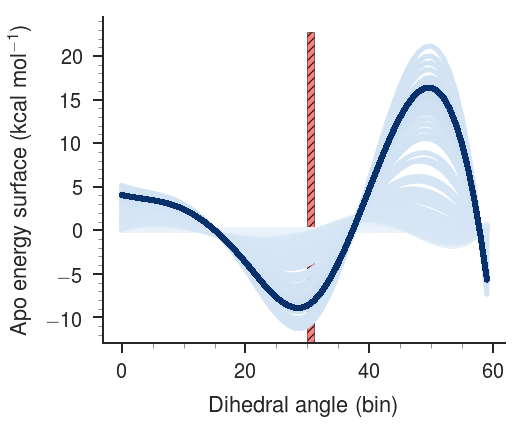

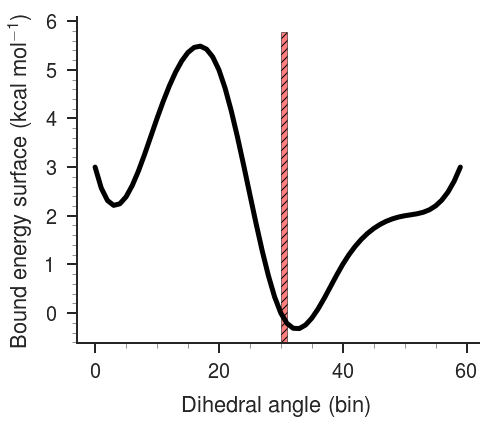

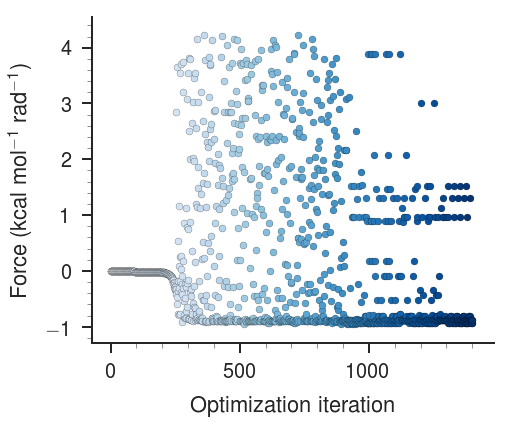

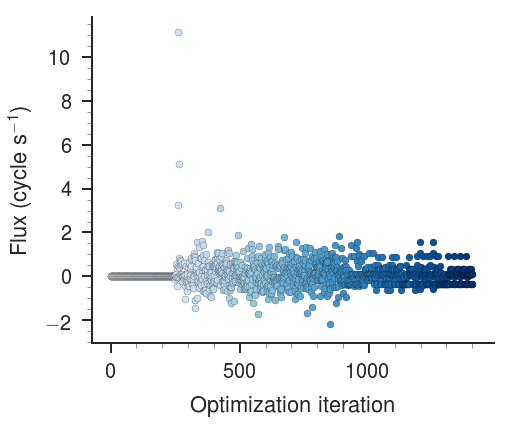

In [12]:
fig = plt.figure(figsize=(6 * 1.2, 6))
grid = GridSpec(1, 1, wspace=0.4, hspace=0.2)
ax1 = plt.subplot(grid[0, 0])
c = sns.color_palette("Blues", n_colors=len(energies))
for index,energy in enumerate(energies):
    ax1.plot(range(60), energy, color=c[index])
bar = ax1.bar(30.5, ax1.get_ylim()[1]-ax1.get_ylim()[0], 1, bottom=ax1.get_ylim()[0], 
              color='red', alpha=0.5, edgecolor='none', lw=1, hatch='///', zorder=0)
ax1.set_xlabel('Dihedral angle (bin)')
ax1.set_ylabel('Apo energy surface (kcal mol$^{-1}$)')
paper_plot(fig)

fig = plt.figure(figsize=(6 * 1.2, 6))
grid = GridSpec(1, 1, wspace=0.4, hspace=0.2)
ax1 = plt.subplot(grid[0, 0])
ax1.plot(range(60), 
         interpolate.spline([0, 10, 20, 30, 40, 50, 59], [3, 4, 5, 0, 1, 2, 3], xnew=np.arange(60)),
         color='k')
bar = ax1.bar(30.5, ax1.get_ylim()[1]-ax1.get_ylim()[0], 1, bottom=ax1.get_ylim()[0], 
              color='red', alpha=0.5, edgecolor='none', lw=1, hatch='///', zorder=0)

ax1.set_xlabel('Dihedral angle (bin)')
ax1.set_ylabel('Bound energy surface (kcal mol$^{-1}$)')
paper_plot(fig)

fig = plt.figure(figsize=(6 * 1.2, 6))
grid = GridSpec(1, 1, wspace=0.4, hspace=0.2)
ax2 = plt.subplot(grid[0, 0])
c = sns.color_palette("Blues", n_colors=len(energies))
for index,force in enumerate(forces):
    ax2.scatter(index, force, color=c[index], lw=0.2, edgecolor='k')
ax2.set_xlabel('Optimization iteration')
ax2.set_ylabel('Force (kcal mol$^{-1}$ rad$^{-1}$)')
paper_plot(fig)

fig = plt.figure(figsize=(6 * 1.2, 6))
grid = GridSpec(1, 1, wspace=0.4, hspace=0.2)
ax2 = plt.subplot(grid[0, 0])
c = sns.color_palette("Blues", n_colors=len(energies))
for index,flux in enumerate(fluxes):
    ax2.scatter(index, flux, color=c[index], lw=0.2, edgecolor='k')
ax2.set_xlabel('Optimization iteration')
ax2.set_ylabel('Flux (cycle s$^{-1}$)')
paper_plot(fig)


## Skip to COBYLA

In [13]:
guess = [0, 0, 0, 0, 0, 0, 0]
forces = []
energies = []
fluxes = []
np.random.seed(42)
results = sc.optimize.minimize(objective, guess, method='COBYLA',
                     bounds=((0, 10), (0, 10), (0, 10),
                             (0, 10), (0, 10), (0, 10),
                             (0, 10)))

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/scipy/optimize/_minimize.py:400: RuntimeWarning: Method COBYLA cannot handle bounds.
  RuntimeWarning)
/media/dslochower/data-beta/projects/nonequilibrium-master/motors/simulation.py:245: ComplexWarning: Casting complex values to real discards the imaginary part
  ss = abs(eigenvectors[:, self.eigenvalues.argmax()].astype(float))


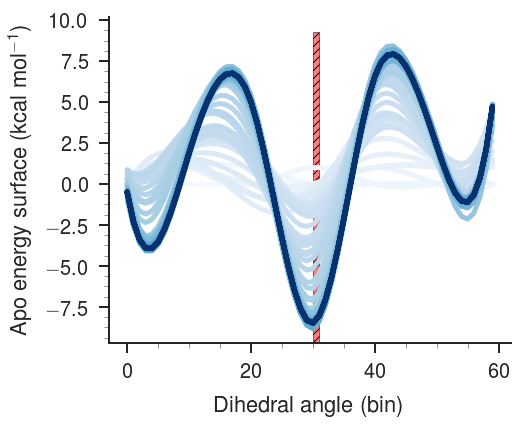

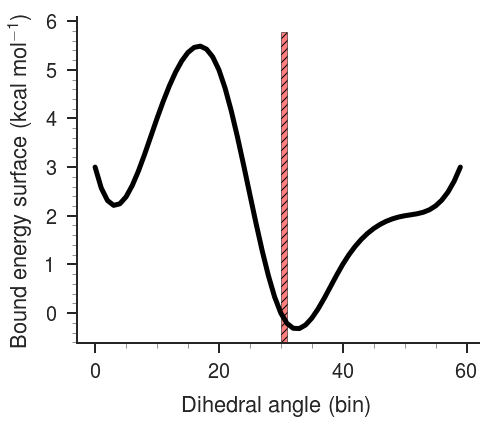

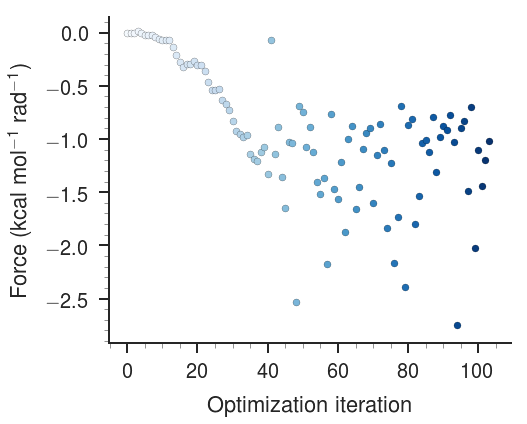

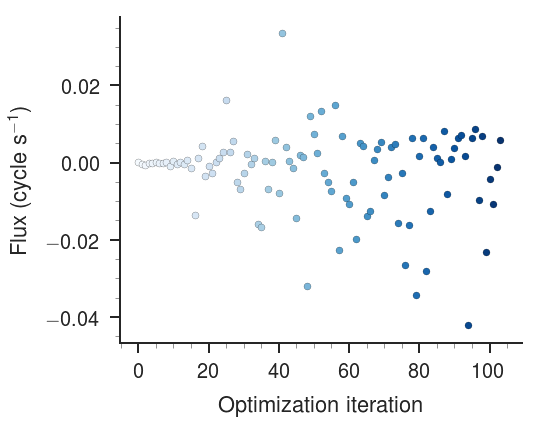

In [14]:
fig = plt.figure(figsize=(6 * 1.2, 6))
grid = GridSpec(1, 1, wspace=0.4, hspace=0.2)
ax1 = plt.subplot(grid[0, 0])
c = sns.color_palette("Blues", n_colors=len(energies))
for index,energy in enumerate(energies):
    ax1.plot(range(60), energy, color=c[index])
bar = ax1.bar(30.5, ax1.get_ylim()[1]-ax1.get_ylim()[0], 1, bottom=ax1.get_ylim()[0], 
              color='red', alpha=0.5, edgecolor='none', lw=1, hatch='///', zorder=0)
ax1.set_xlabel('Dihedral angle (bin)')
ax1.set_ylabel('Apo energy surface (kcal mol$^{-1}$)')
paper_plot(fig)

fig = plt.figure(figsize=(6 * 1.2, 6))
grid = GridSpec(1, 1, wspace=0.4, hspace=0.2)
ax1 = plt.subplot(grid[0, 0])
ax1.plot(range(60), 
         interpolate.spline([0, 10, 20, 30, 40, 50, 59], [3, 4, 5, 0, 1, 2, 3], xnew=np.arange(60)),
         color='k')
bar = ax1.bar(30.5, ax1.get_ylim()[1]-ax1.get_ylim()[0], 1, bottom=ax1.get_ylim()[0], 
              color='red', alpha=0.5, edgecolor='none', lw=1, hatch='///', zorder=0)

ax1.set_xlabel('Dihedral angle (bin)')
ax1.set_ylabel('Bound energy surface (kcal mol$^{-1}$)')
paper_plot(fig)

fig = plt.figure(figsize=(6 * 1.2, 6))
grid = GridSpec(1, 1, wspace=0.4, hspace=0.2)
ax2 = plt.subplot(grid[0, 0])
c = sns.color_palette("Blues", n_colors=len(energies))
for index,force in enumerate(forces):
    ax2.scatter(index, force, color=c[index], lw=0.2, edgecolor='k')
ax2.set_xlabel('Optimization iteration')
ax2.set_ylabel('Force (kcal mol$^{-1}$ rad$^{-1}$)')
paper_plot(fig)

fig = plt.figure(figsize=(6 * 1.2, 6))
grid = GridSpec(1, 1, wspace=0.4, hspace=0.2)
ax2 = plt.subplot(grid[0, 0])
c = sns.color_palette("Blues", n_colors=len(energies))
for index,flux in enumerate(fluxes):
    ax2.scatter(index, flux, color=c[index], lw=0.2, edgecolor='k')
ax2.set_xlabel('Optimization iteration')
ax2.set_ylabel('Flux (cycle s$^{-1}$)')
paper_plot(fig)

## Add the pinned objective function so energies are in [0, 10)

In [15]:
def objective_pinned(spline_points):
    
    
    spline_x = [0, 10, 20, 30, 40, 50, 59]
    full_x   = np.arange(60)
    
    for index, point in enumerate(spline_points):
        if point >= 10:
            spline_points[index] = 10
        if point <= 0:
            spline_points[index] = 0
            
    energy = interpolate.spline(spline_x, spline_points, xnew=full_x)
    energies.append(energy)  
    
    force, flux = report_force_on_barrier(energy, interpolate.spline(spline_x, [3, 4, 5, 0, 1, 2, 3], xnew=full_x), 
                            position=30)
    
    forces.append(force)
    fluxes.append(flux)
    return force


In [16]:
guess = [0, 0, 0, 0, 0, 0, 0]
forces = []
energies = []
fluxes = []
np.random.seed(42)
results = sc.optimize.minimize(objective_pinned, guess, method='COBYLA',
                     bounds=((0, 10), (0, 10), (0, 10),
                             (0, 10), (0, 10), (0, 10),
                             (0, 10)))

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/scipy/optimize/_minimize.py:400: RuntimeWarning: Method COBYLA cannot handle bounds.
  RuntimeWarning)


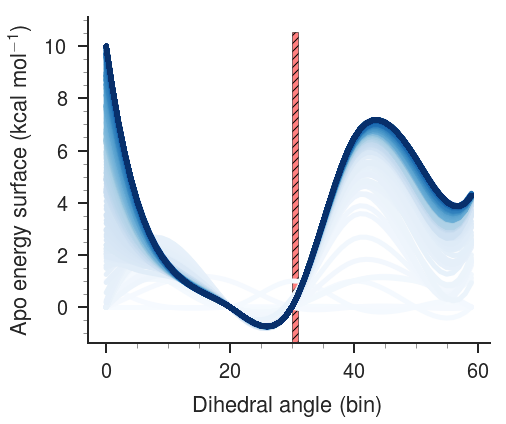

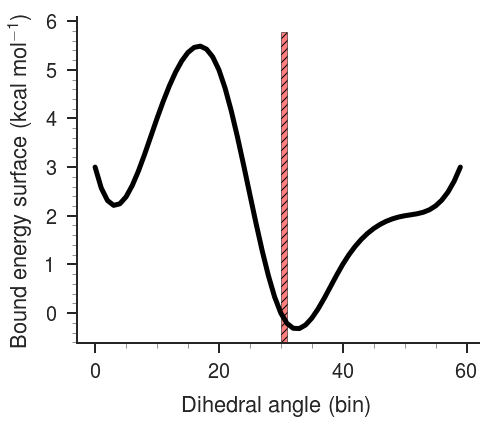

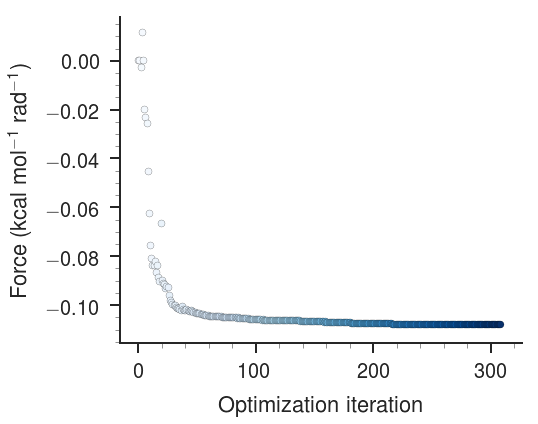

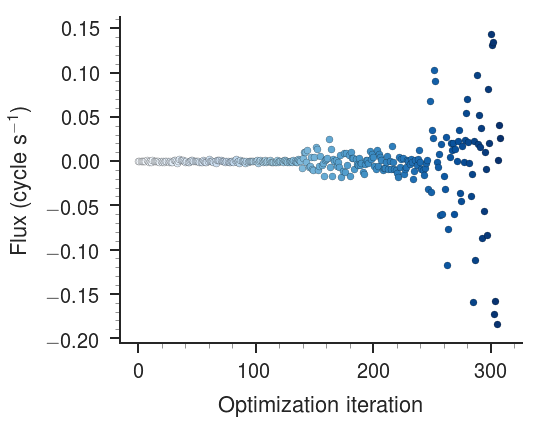

In [17]:
fig = plt.figure(figsize=(6 * 1.2, 6))
grid = GridSpec(1, 1, wspace=0.4, hspace=0.2)
ax1 = plt.subplot(grid[0, 0])
c = sns.color_palette("Blues", n_colors=len(energies))
for index,energy in enumerate(energies):
    ax1.plot(range(60), energy, color=c[index])
bar = ax1.bar(30.5, ax1.get_ylim()[1]-ax1.get_ylim()[0], 1, bottom=ax1.get_ylim()[0], 
              color='red', alpha=0.5, edgecolor='none', lw=1, hatch='///', zorder=0)
ax1.set_xlabel('Dihedral angle (bin)')
ax1.set_ylabel('Apo energy surface (kcal mol$^{-1}$)')
paper_plot(fig)

fig = plt.figure(figsize=(6 * 1.2, 6))
grid = GridSpec(1, 1, wspace=0.4, hspace=0.2)
ax1 = plt.subplot(grid[0, 0])
ax1.plot(range(60), 
         interpolate.spline([0, 10, 20, 30, 40, 50, 59], [3, 4, 5, 0, 1, 2, 3], xnew=np.arange(60)),
         color='k')
bar = ax1.bar(30.5, ax1.get_ylim()[1]-ax1.get_ylim()[0], 1, bottom=ax1.get_ylim()[0], 
              color='red', alpha=0.5, edgecolor='none', lw=1, hatch='///', zorder=0)

ax1.set_xlabel('Dihedral angle (bin)')
ax1.set_ylabel('Bound energy surface (kcal mol$^{-1}$)')
paper_plot(fig)

fig = plt.figure(figsize=(6 * 1.2, 6))
grid = GridSpec(1, 1, wspace=0.4, hspace=0.2)
ax2 = plt.subplot(grid[0, 0])
c = sns.color_palette("Blues", n_colors=len(energies))
for index,force in enumerate(forces):
    ax2.scatter(index, force, color=c[index], lw=0.2, edgecolor='k')
ax2.set_xlabel('Optimization iteration')
ax2.set_ylabel('Force (kcal mol$^{-1}$ rad$^{-1}$)')
paper_plot(fig)

fig = plt.figure(figsize=(6 * 1.2, 6))
grid = GridSpec(1, 1, wspace=0.4, hspace=0.2)
ax2 = plt.subplot(grid[0, 0])
c = sns.color_palette("Blues", n_colors=len(energies))
for index,flux in enumerate(fluxes):
    ax2.scatter(index, flux, color=c[index], lw=0.2, edgecolor='k')
ax2.set_xlabel('Optimization iteration')
ax2.set_ylabel('Flux (cycle s$^{-1}$)')
paper_plot(fig)

## Powell's method with pinned objective function

In [18]:
guess = [0, 0, 0, 0, 0, 0, 0]
forces = []
energies = []
fluxes = []
np.random.seed(42)
results = sc.optimize.minimize(objective_pinned, guess, method='Powell',
                     bounds=((0, 10), (0, 10), (0, 10),
                             (0, 10), (0, 10), (0, 10),
                             (0, 10)))

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/scipy/optimize/_minimize.py:394: RuntimeWarning: Method Powell cannot handle constraints nor bounds.
  RuntimeWarning)


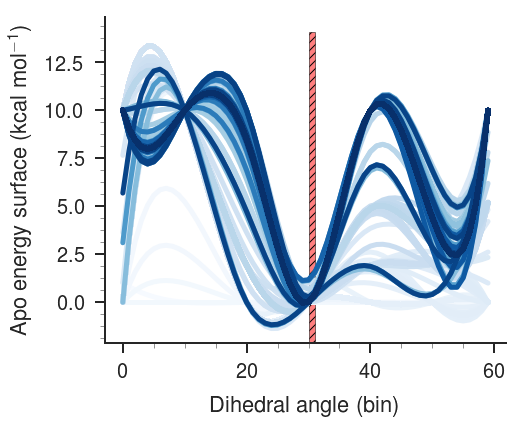

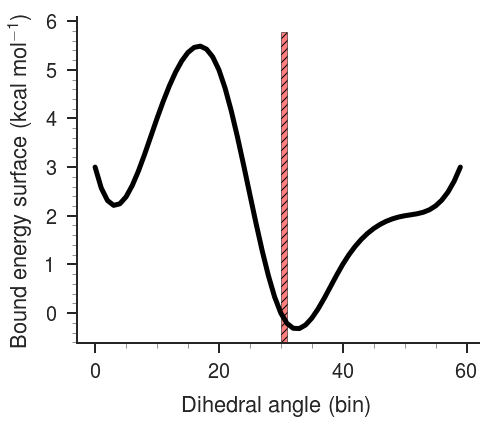

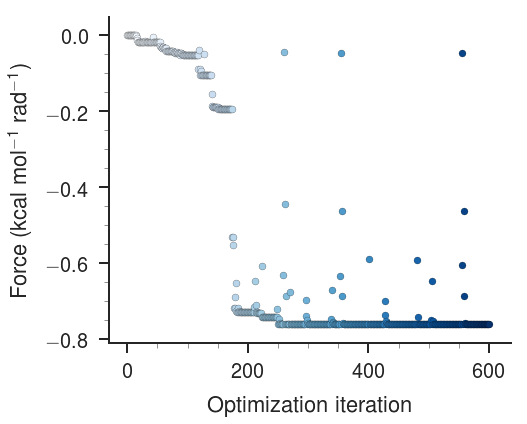

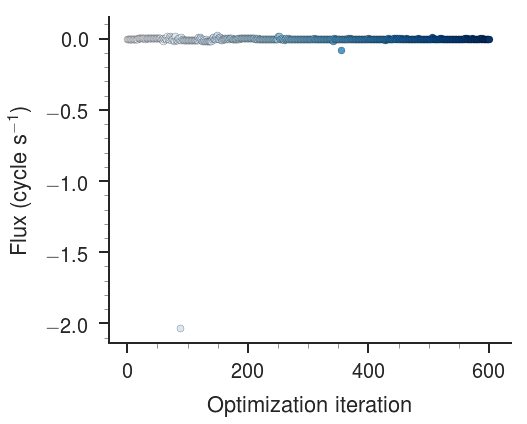

In [19]:
fig = plt.figure(figsize=(6 * 1.2, 6))
grid = GridSpec(1, 1, wspace=0.4, hspace=0.2)
ax1 = plt.subplot(grid[0, 0])
c = sns.color_palette("Blues", n_colors=len(energies))
for index,energy in enumerate(energies):
    ax1.plot(range(60), energy, color=c[index])
bar = ax1.bar(30.5, ax1.get_ylim()[1]-ax1.get_ylim()[0], 1, bottom=ax1.get_ylim()[0], 
              color='red', alpha=0.5, edgecolor='none', lw=1, hatch='///', zorder=0)
ax1.set_xlabel('Dihedral angle (bin)')
ax1.set_ylabel('Apo energy surface (kcal mol$^{-1}$)')
paper_plot(fig)

fig = plt.figure(figsize=(6 * 1.2, 6))
grid = GridSpec(1, 1, wspace=0.4, hspace=0.2)
ax1 = plt.subplot(grid[0, 0])
ax1.plot(range(60), 
         interpolate.spline([0, 10, 20, 30, 40, 50, 59], [3, 4, 5, 0, 1, 2, 3], xnew=np.arange(60)),
         color='k')
bar = ax1.bar(30.5, ax1.get_ylim()[1]-ax1.get_ylim()[0], 1, bottom=ax1.get_ylim()[0], 
              color='red', alpha=0.5, edgecolor='none', lw=1, hatch='///', zorder=0)

ax1.set_xlabel('Dihedral angle (bin)')
ax1.set_ylabel('Bound energy surface (kcal mol$^{-1}$)')
paper_plot(fig)

fig = plt.figure(figsize=(6 * 1.2, 6))
grid = GridSpec(1, 1, wspace=0.4, hspace=0.2)
ax2 = plt.subplot(grid[0, 0])
c = sns.color_palette("Blues", n_colors=len(energies))
for index,force in enumerate(forces):
    ax2.scatter(index, force, color=c[index], lw=0.2, edgecolor='k')
ax2.set_xlabel('Optimization iteration')
ax2.set_ylabel('Force (kcal mol$^{-1}$ rad$^{-1}$)')
paper_plot(fig)

fig = plt.figure(figsize=(6 * 1.2, 6))
grid = GridSpec(1, 1, wspace=0.4, hspace=0.2)
ax2 = plt.subplot(grid[0, 0])
c = sns.color_palette("Blues", n_colors=len(energies))
for index,flux in enumerate(fluxes):
    ax2.scatter(index, flux, color=c[index], lw=0.2, edgecolor='k')
ax2.set_xlabel('Optimization iteration')
ax2.set_ylabel('Flux (cycle s$^{-1}$)')
paper_plot(fig)

# It seems hard to optimize a surface with such a higher barrier. Let's just try co-optimization of two surfaces, for flux, without a barrier and then start adding in a barrier slowly using the flux-optimized surfaces as a starting point

## Optimize for flux

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/scipy/optimize/_minimize.py:400: RuntimeWarning: Method COBYLA cannot handle bounds.
  RuntimeWarning)


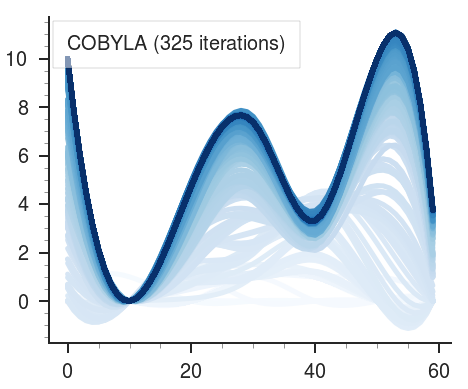

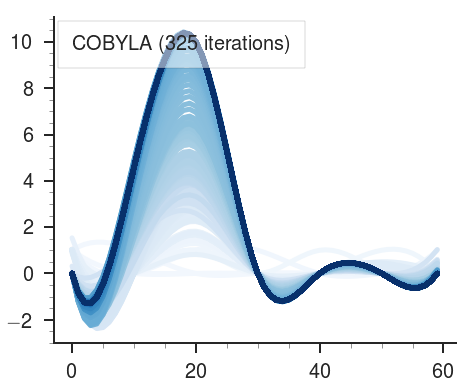

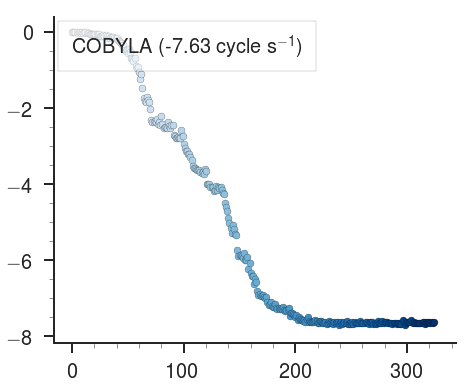

In [21]:
def objective_pinned(spline_points):
    spline_x = [0, 10, 20, 30, 40, 50, 59]
    full_x   = np.arange(60)
        
    for index, point in enumerate(spline_points):
        if point >= 10:
            spline_points[index] = 10
        if point <= 0:
            spline_points[index] = 0
    
    apo   = interpolate.spline(spline_x, spline_points[0:len(spline_x)], xnew=full_x)
    bound = interpolate.spline(spline_x, spline_points[len(spline_x):2 * len(spline_x)], xnew=full_x)
    
    apos.append(apo)
    bounds.append(bound)
    
    this = Simulation(data_source = 'manual')
    this.unbound = apo
    this.bound = bound

    this.C_intersurface = 10 ** 6     # per mole per second
    this.offset_factor = 5.7          # kcal per mol
    this.catalytic_rate = 312         # per second
    this.cSubstrate = 2.5 * 10 ** -3

    this.simulate(user_energies=True)
    fluxes.append(np.mean(this.flux_u + this.flux_b))
    return np.mean(this.flux_u + this.flux_b)


def plot_results(apos, bounds, fluxes, method, iterations):
    fig = plt.figure(figsize=(6 * 1.2, 6))
    grid = GridSpec(1, 1, wspace=0.4, hspace=0.2)
    ax1 = plt.subplot(grid[0, 0])
    c = sns.color_palette("Blues", n_colors=len(apos))
    for index,energy in enumerate(apos):
        ax1.plot(range(60), energy, color=c[index])
    from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
    at = AnchoredText('{} ({} iterations)'.format(method, iterations),
                      prop=dict(size=20), frameon=True, loc=2
    )
    at.patch.set(boxstyle='square', alpha=0.5)
    ax1.add_artist(at)
    paper_plot(fig)
    plt.show()
    
    fig = plt.figure(figsize=(6 * 1.2, 6))
    grid = GridSpec(1, 1, wspace=0.4, hspace=0.2)
    ax1 = plt.subplot(grid[0, 0])
    c = sns.color_palette("Blues", n_colors=len(apos))
    for index,energy in enumerate(bounds):
        ax1.plot(range(60), energy, color=c[index])
    from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
    at = AnchoredText('{} ({} iterations)'.format(method, iterations),
                      prop=dict(size=20), frameon=True, loc=2
    )
    at.patch.set(boxstyle='square', alpha=0.5)
    ax1.add_artist(at)
    paper_plot(fig)
    plt.show()

    fig = plt.figure(figsize=(6 * 1.2, 6))
    grid = GridSpec(1, 1, wspace=0.4, hspace=0.2)
    ax2 = plt.subplot(grid[0, 0])
    c = sns.color_palette("Blues", n_colors=len(apos))
    for index,flux in enumerate(fluxes):
        ax2.scatter(index, flux, color=c[index], lw=0.2, edgecolor='k')
    at = AnchoredText('{0} ({1:4.2f} cycle s$^ {{-1}}$)'.format(method, fluxes[-1]),
                      prop=dict(size=20), frameon=True, loc=2
    )
    at.patch.set(boxstyle='square', alpha=0.5)
    ax2.add_artist(at)
    paper_plot(fig)
    plt.show()
    
guess = [0, 0, 0, 0, 0, 0, 0]*2
apos = []
bounds = []
fluxes = []
np.random.seed(42)
results = sc.optimize.minimize(objective_pinned, guess, method='COBYLA',
                     bounds=((0, 0.1), (0, 10), (0, 10),
                             (0, 10), (0, 10), (0, 10),
                             (0, 10), (0, 10), (0, 10),
                             (0, 10), (0, 10), (0, 10),
                             (0, 10), (0, 10)))


plot_results(apos, bounds, fluxes, 'COBYLA', results['nfev'])

## Now let's add a small barrier of just 1 kcal/mol at position 30

/home/dslochower/data/applications/anaconda3/lib/python3.6/site-packages/scipy/optimize/_minimize.py:394: RuntimeWarning: Method Powell cannot handle constraints nor bounds.
  RuntimeWarning)


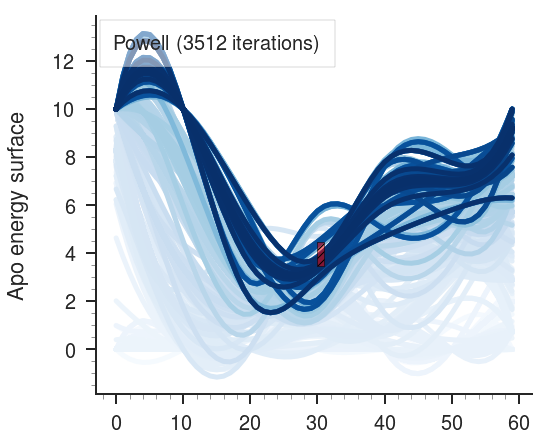

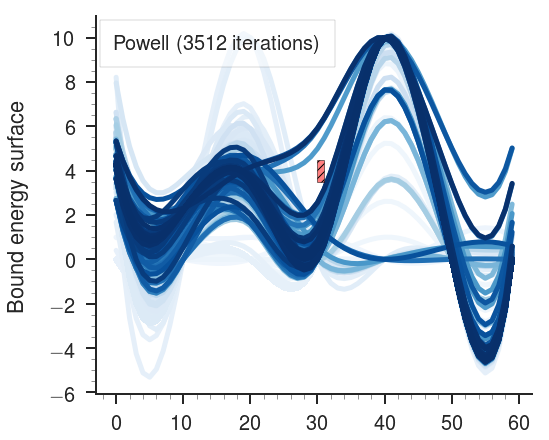

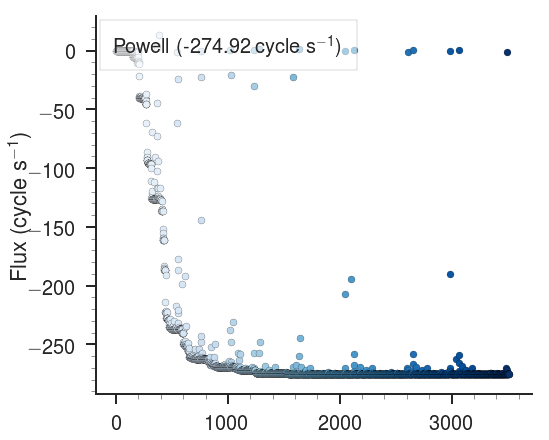

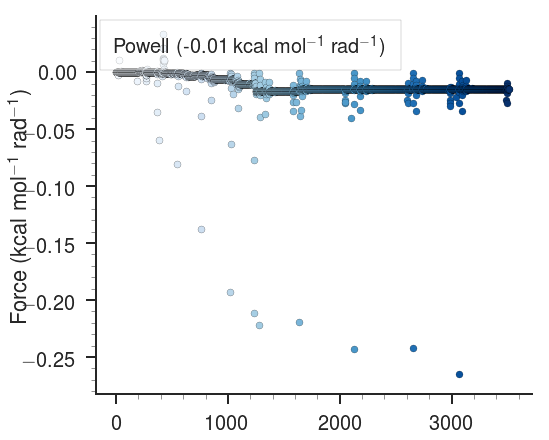

In [95]:
def objective_pinned_with_force(spline_points):
    spline_x = [0, 10, 20, 30, 40, 50, 59]
    full_x   = np.arange(60)
        
    for index, point in enumerate(spline_points):
        if point >= 10:
            spline_points[index] = 10
        if point <= 0:
            spline_points[index] = 0
    
    apo   = interpolate.spline(spline_x, spline_points[0:len(spline_x)], xnew=full_x)
    bound = interpolate.spline(spline_x, spline_points[len(spline_x):2 * len(spline_x)], xnew=full_x)
    
    apos.append(apo)
    bounds.append(bound)
    
    force, flux = report_force_on_barrier(apo, bound, position=30, height=1)
    
    fluxes.append(flux)
    forces.append(force)

    return flux

def plot_results_with_force(apos, bounds, fluxes, method, iterations, forces,
                           barrier_position=30, barrier_height=1):
    

    fig, ax = setup_plot('Apo energy surface', '')
    c = sns.color_palette("Blues", n_colors=len(apos))
    for index,energy in enumerate(apos):
        ax.plot(range(60), energy, color=c[index])
    bar = ax.bar(left=barrier_position+0.5, height=barrier_height, width=1, bottom=apos[-1][barrier_position], 
          color='red', alpha=0.5, edgecolor='none', lw=1, hatch='///', zorder=10)

    from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
    at = AnchoredText('{} ({} iterations)'.format(method, iterations),
                      prop=dict(size=20), frameon=True, loc=2
    )
    at.patch.set(boxstyle='square', alpha=0.5)
    ax.add_artist(at)
    paper_plot(fig)
    plt.show()
    
    fig, ax = setup_plot('Bound energy surface', '')
    for index,energy in enumerate(bounds):
        ax.plot(range(60), energy, color=c[index])
    bar = ax.bar(left=barrier_position+0.5, height=barrier_height, width=1, bottom=apos[-1][barrier_position], 
          color='red', alpha=0.5, edgecolor='none', lw=1, hatch='///', zorder=10)
    from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
    at = AnchoredText('{} ({} iterations)'.format(method, iterations),
                      prop=dict(size=20), frameon=True, loc=2
    )
    at.patch.set(boxstyle='square', alpha=0.5)
    ax.add_artist(at)
    paper_plot(fig)
    plt.show()

    fig, ax = setup_plot('Flux (cycle s$^{{-1}}$)', '')
    for index,flux in enumerate(fluxes):
        ax.scatter(index, flux, color=c[index], lw=0.2, edgecolor='k')
    at = AnchoredText('{0} ({1:4.2f} cycle s$^ {{-1}}$)'.format(method, fluxes[-1]),
                      prop=dict(size=20), frameon=True, loc=2
    )
    at.patch.set(boxstyle='square', alpha=0.5)
    ax.add_artist(at)
    paper_plot(fig)
    plt.show()
    
    fig, ax = setup_plot('Force (kcal mol$^{{-1}}$ rad$^{{-1}}$)', '')
    for index,force in enumerate(forces):
        ax.scatter(index, force, color=c[index], lw=0.2, edgecolor='k')
    at = AnchoredText('{0} ({1:4.2f} kcal mol$^ {{-1}}$ rad$^{{-1}}$)'.format(method, forces[-1]),
                      prop=dict(size=20), frameon=True, loc=2
    )
    at.patch.set(boxstyle='square', alpha=0.5)
    ax.add_artist(at)
    paper_plot(fig)
    plt.show()


guess = [0, 0, 0, 0, 0, 0, 0]*2
apos = []
bounds = []
fluxes = []
forces = []
np.random.seed(42)
results = sc.optimize.minimize(objective_pinned_with_force, guess, method='Powell',
                     bounds=((0, 0.1), (0, 10), (0, 10),
                             (0, 10), (0, 10), (0, 10),
                             (0, 10), (0, 10), (0, 10),
                             (0, 10), (0, 10), (0, 10),
                             (0, 10), (0, 10)))

plot_results_with_force(apos, bounds, fluxes, 'Powell', results['nfev'], forces)

In [87]:
from motors.aesthetics import setup_plot